# Import Library

In [1]:
!pip install transformers datasets --quiet
!pip install emoji --quiet
!pip install wordcloud --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12

In [2]:
import re
import string
import numpy as np
import pandas as pd
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Dicoding/3. Belajar Pengembangan Machine Learning/sentimen-analysis"

df = pd.read_csv(f"{path}/tokopedia_reviews.csv")

# Labeling

In [5]:
def label_sentiment(df):
    classifier = pipeline(
        "text-classification",
        model="w11wo/indonesian-roberta-base-sentiment-classifier",
        tokenizer="w11wo/indonesian-roberta-base-sentiment-classifier",
        truncation=True,
        padding=True,
        max_length=512
    )

    df['label'] = df['review'].astype(str).apply(lambda x: classifier(x)[0]['label'].lower())
    return df

df = label_sentiment(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [6]:
df['label'].value_counts()

,count
label,
negative,2368
positive,2132
neutral,300


# Oversampling

In [7]:
df_positif = df[df['label'] == 'positive']
df_negatif = df[df['label'] == 'negative']
df_netral  = df[df['label'] == 'neutral']

df_negatif_upsampled = resample(df_negatif,
                                 replace=True,
                                 n_samples=len(df_positif),
                                 random_state=42)

df_netral_upsampled = resample(df_netral,
                                replace=True,
                                n_samples=len(df_positif),
                                random_state=42)

df_balanced = pd.concat([df_positif, df_negatif_upsampled, df_netral_upsampled])

In [8]:
df_balanced['label'].value_counts()

,count
label,
positive,2132
negative,2132
neutral,2132


# EDA

In [9]:
def generate_wordcloud(df, label_name):
    text = ' '.join(df[df['label'] == label_name]['review'].tolist())
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        collocations=False,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"sentimen: {label_name}", fontsize=16)
    plt.show()

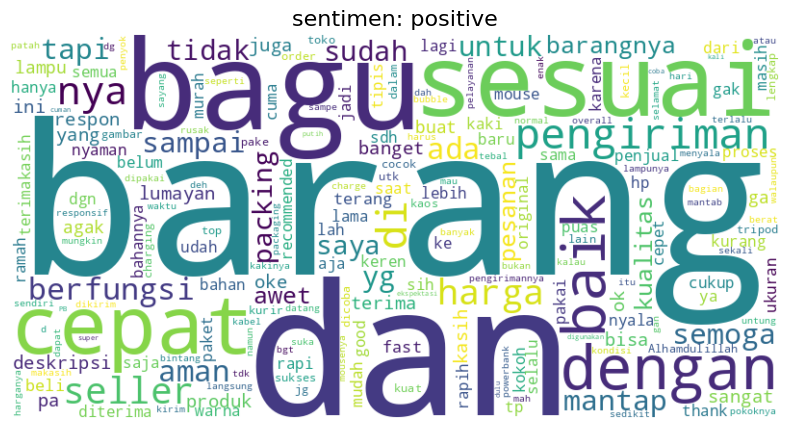

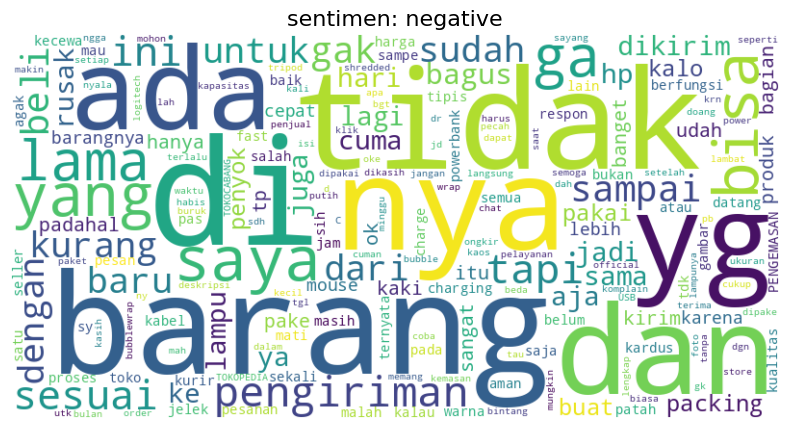

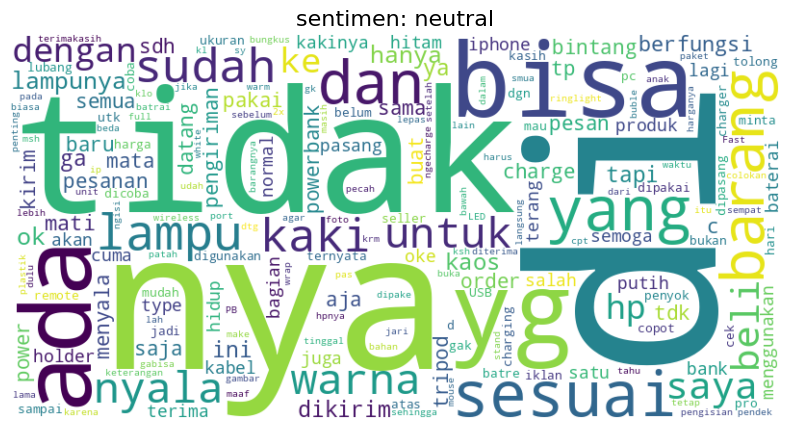

In [10]:
for label in df_balanced['label'].unique():
    generate_wordcloud(df_balanced, label)

# Preprocessing

In [11]:
kamus_alay = {
    'gk': 'nggak',
    'ga': 'nggak',
    'bgt': 'banget',
    'tp': 'tapi',
    'udh': 'sudah',
    'sy': 'saya',
    'dr': 'dari',
    'blm': 'belum',
    'tdk': 'tidak',
    'sbnrnya': 'sebenarnya',
    'bbrp': 'beberapa',
    'dpt': 'dapat',
    'trs': 'terus',
    'bgt': 'banget',
    'jg': 'juga',
    'krn': 'karena',
    'sm': 'sama',
    'udh': 'sudah',
    'aja': 'saja',
    'lg': 'lagi'
}

def normalize_text(text):
    return ' '.join([kamus_alay.get(w, w) for w in text.split()])

def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = normalize_text(text)

    return text.strip()

In [12]:
df_balanced['cleaned_review'] = df_balanced['review'].astype(str).apply(clean_text)
df_balanced[['review', 'cleaned_review', 'label']].sample(5)

,review,cleaned_review,label
4178,"mouse bisa di gunakan, tp lampu nya tidak menyala",mouse bisa di gunakan tapi lampu nya tidak men...,neutral
3727,Pengiriman instan sangat lama… barang dikirm t...,pengiriman instan sangat lama barang dikirm td...,negative
2910,beli krn lucu tp powerbanknya ga ky powerbank ...,beli karena lucu tapi powerbanknya nggak ky po...,negative
1970,casenya bagus,casenya bagus,positive
1844,respond cepat packing rapi,respond cepat packing rapi,positive


# Tokenize & Encoding

In [13]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
texts = df_balanced['cleaned_review'].tolist()
labels = df_balanced['label'].tolist()

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

tokenized = tokenizer.batch_encode_plus(
    texts,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Label mapping: {np.str_('negative'): np.int64(0), np.str_('neutral'): np.int64(1), np.str_('positive'): np.int64(2)}


# Create Dataset & Data Loader

## Custom Dataset Class

In [15]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Split Train & Validation Set

In [16]:
train_idx, val_idx = train_test_split(
    list(range(len(encoded_labels))),
    test_size=0.1,
    stratify=encoded_labels,
    random_state=42
)

train_encodings = {key: val[train_idx] for key, val in tokenized.items()}
val_encodings   = {key: val[val_idx] for key, val in tokenized.items()}

train_labels = [encoded_labels[i] for i in train_idx]
val_labels   = [encoded_labels[i] for i in val_idx]

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset   = ReviewDataset(val_encodings, val_labels)

# Modeling

## Fine-Tuning IndoBERT

In [17]:
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=3
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-20-2a6fcecac192>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: putrallan03 (putrallan03-gadjah-mada-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.385400,0.340785,0.862500,0.866404,0.862592,0.862848
2,0.210600,0.195593,0.929688,0.929681,0.929724,0.929657
3,0.125200,0.338034,0.929688,0.931933,0.929811,0.929149
4,0.012600,0.356368,0.932813,0.932652,0.932876,0.932419
5,0.001500,0.345008,0.935937,0.936058,0.936013,0.935660


<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=1800, training_loss=0.2174140370425044, metrics={'train_runtime': 781.6675, 'train_samples_per_second': 36.819, 'train_steps_per_second': 2.303, 'total_flos': 1893101040552960.0, 'train_loss': 0.2174140370425044, 'epoch': 5.0})

## Evaluation

In [22]:
trainer.evaluate()

<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.3450084328651428,
 'eval_accuracy': 0.9359375,
 'eval_precision': 0.9360579893605799,
 'eval_recall': 0.9360127535723165,
 'eval_f1': 0.9356600189933523,
 'eval_runtime': 4.708,
 'eval_samples_per_second': 135.94,
 'eval_steps_per_second': 8.496,
 'epoch': 5.0}

In [30]:
val_predictions = trainer.predict(val_dataset)

y_pred = np.argmax(val_predictions.predictions, axis=1)
y_true = val_predictions.label_ids

y_pred_labels = [le.inverse_transform([i])[0] for i in y_pred]
y_true_labels = [le.inverse_transform([i])[0] for i in y_true]

print(classification_report(y_true_labels, y_pred_labels, digits=4))

<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

    negative     0.9041    0.9296    0.9167       213
     neutral     0.9635    0.9906    0.9769       213
    positive     0.9406    0.8879    0.9135       214

    accuracy                         0.9359       640
   macro avg     0.9361    0.9360    0.9357       640
weighted avg     0.9361    0.9359    0.9356       640



## Save Model

In [31]:
model.save_pretrained(f"{path}/model-sentimen-indobert")
tokenizer.save_pretrained(f"{path}/model-sentimen-indobert")

('/content/drive/MyDrive/Dicoding/3. Belajar Pengembangan Machine Learning/sentimen-analysis/model-sentimen-indobert/tokenizer_config.json',
 '/content/drive/MyDrive/Dicoding/3. Belajar Pengembangan Machine Learning/sentimen-analysis/model-sentimen-indobert/special_tokens_map.json',
 '/content/drive/MyDrive/Dicoding/3. Belajar Pengembangan Machine Learning/sentimen-analysis/model-sentimen-indobert/vocab.txt',
 '/content/drive/MyDrive/Dicoding/3. Belajar Pengembangan Machine Learning/sentimen-analysis/model-sentimen-indobert/added_tokens.json')

# Testing

In [32]:
new_texts = [
    "barang jelek, tdk sesuai kualitas yang tertera",
    "Sesuai Des, sejuh ini cukup baik",
    "Sebaiknya diinformasikan tidak tersedia kabel type c to type c yg hubungkan powerbank dgn HP"
]

In [33]:
new_texts_clean = [clean_text(t) for t in new_texts]

inputs = tokenizer(
    new_texts_clean,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128
)

In [34]:
dummy_labels = [0] * len(new_texts_clean)
new_dataset = ReviewDataset(inputs, dummy_labels)

predictions = trainer.predict(new_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

<ipython-input-15-18c5d0574307>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
label_decode = {v: k for k, v in label_mapping.items()}

for text, label in zip(new_texts, pred_labels):
    print(f"Review Product:\n{text}\nPredict Sentimen: {label_decode[label]}\n")

Review Product:
barang jelek, tdk sesuai kualitas yang tertera
Predict Sentimen: negative

Review Product:
Sesuai Des, sejuh ini cukup baik
Predict Sentimen: positive

Review Product:
Sebaiknya diinformasikan tidak tersedia kabel type c to type c yg hubungkan powerbank dgn HP
Predict Sentimen: neutral

